# rdkit 分子3D构象生成与优化
RDKit是一款非常强大的分子信息学工具包，其中包含了分子3D构象生成与优化的功能。通过RDKit，您可以将一个分子的2D结构转化为3D结构，并进行能量最小化优化，得到最稳定的构象。

## 构象生成算法概述
- 基于距离（distance-based）
- 基于知识（knowledge-based）

下面是基本代码逻辑

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# 读入分子SMILES字符串
mol = Chem.MolFromSmiles('CC(=O)OC1=CC=CC=C1C(=O)O')

# 生成初始3D构象
AllChem.EmbedMolecule(mol)

# 进行能量最小化优化
AllChem.MMFFOptimizeMolecule(mol)

# 输出优化后的3D结构
print(Chem.MolToMolBlock(mol))



     RDKit          3D

 13 13  0  0  0  0  0  0  0  0999 V2000
    2.8746   -1.9481    0.7697 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4519   -1.4942    0.7243 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6610   -1.5944    1.6526 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.1953   -0.9612   -0.5309 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1020   -0.4535   -0.6230 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0417   -1.2552   -1.2736 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.3498   -0.8037   -1.4186 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7129    0.4472   -0.9263 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7653    1.2531   -0.2971 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4475    0.8156   -0.1433 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5472    1.7048    0.4969 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.7485    1.4985    0.5415 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0592    2.7912    1.0278 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  2  0

[08:51:13] Molecule does not have explicit Hs. Consider calling AddHs()
[08:51:13] Molecule does not have explicit Hs. Consider calling AddHs()


## 基于距离（distance-based）

传统的距离几何（Distance Geometry）法生成构象步骤：

- (1) 通过分子的连接表信息和一套规则，生成分子的连接边界矩阵（molecule’s distance bounds matrix ）
- (2) 使用三角形边界平滑算法（triangle-bounds smoothing algorithm），对边界矩阵进行平滑处理
- (3) 根据边界矩阵，随机产生一个距离矩阵。
- (4) 把产生的距离矩阵映射到三维空间中，并为每个原子计算坐标。
- (5) 对计算的坐标结果使用力场和边界矩阵进行粗略的优化。

这种方法虽然计算速度快，也能得到分子的三维坐标，但纯粹基于距离计算会导致部分结构的扭曲，也就是结果比较丑。想得到更好的结构，需要进行更细致的力场优化，比如再使用rdkit的通用力场（Universal Force Field，UFF）进行处理。

## 基于知识（knowledge-based）
Riniker和Landrum开发了一种（Experimental-Torsion Basic Knowledge Distance Geometry，ETKDG）的方法。他们从晶体结构数据库的小分子结构中总结了一些规则（扭转角的倾向性，torsion angle preference，符合某种SMARTS的结构更倾向于生成某种固定的构象），并用这套规则来修正距离几何算法产生的构象。如果使用了ETKDG，就可以不再使用力场进行优化了。

在rdkit中，目前已经将ETKDG作为默认的构象生成方法。使用代码实现这种方法比上面的废话都要简单，几行代码就能搞定了。


### 代码示例



In [2]:
mol = Chem.MolFromSmiles('CC1=CC=C(C=C1)NC2=C3C(=C(C=C2)NC4=CC=C(C=C4)C)C(=O)C5=CC=CC=C5C3=O')
m3d = Chem.AddHs(mol)
print(mol.GetNumAtoms(), m3d.GetNumAtoms())


32 54


## 距离几何算法生成3D结构
使用距离几何算法初始化3D坐标。

生成3D构象：`AllChem.EmbedMolecule(mol, randomSeed, clearConfs, useExpTorsionAnglePrefs, useBasicKnowledge, …)`
- mol：传入mol对象
- randomSeed：随机种子，方便结果重复
- clearConfs：清除已有构象，默认True
- useExpTorsionAnglePrefs和useBasicKnowledge两个参数即控制是否使用ETKDG，默认都为True


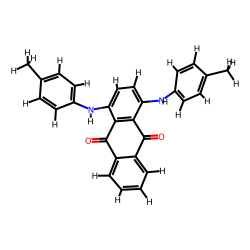

In [3]:
AllChem.EmbedMolecule(m3d, randomSeed=10, useExpTorsionAnglePrefs=False, useBasicKnowledge=False)
Draw.MolToImage(m3d, size=(250,250))


## 距离几何+ETKDG生成3D构象
生成3D构象：`AllChem.EmbedMolecule()`
先用距离几何初始化3D坐标，再使用ETKDG算法优化
参数同上，默认`useExpTorsionAnglePrefs`和`useBasicKnowledge`为True



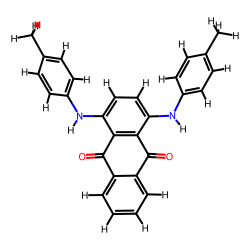

In [4]:
AllChem.EmbedMolecule(m3d, randomSeed=10)
Draw.MolToImage(m3d, size=(250,250))


## 距离几何+ETKDG生成多构象

生成多个构象：`AllChem.EmbedMultipleConfs(mol, numConfs, maxAttempts, randomSeed, clearConfs, pruneRmsThresh, useExpTorsionAnglePrefs, useBasicKnowledge, …)`

其中numConfs控制了生成构象的个数。
- `mol`：mol对象
- `numConfs`：生成的构象数量
- `maxAttempts`：尝试生成构象的最多次数
- `randomSeed`：随机种子
- `clearConfs`：清除已有构象
- `pruneRmsThresh`：根据RMS进行合并
- `ETKDG`相关参数同上


In [5]:
cids = AllChem.EmbedMultipleConfs(m3d, numConfs=10)
print(len(cids))


10


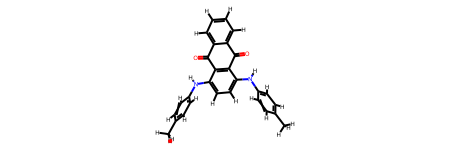

In [6]:
m3d

获取某个构象GetConformer(id)
通过传入id获取指定构象

In [7]:
# 获取第n个构象
conformer = m3d.GetConformer(id=6)

# 将Conformer对象添加到Mol对象中
m3d.AddConformer(conformer)

6

将Conformer类转为Mol类

In [17]:
mol.GetConformer?

Docstring:
GetConformer( (Mol)self [, (int)id=-1]) -> Conformer :
    Get the conformer with a specified ID

    C++ signature :
        RDKit::Conformer* GetConformer(RDKit::ROMol {lvalue} [,int=-1])
Type:      method


In [22]:
from rdkit import Chem

# 创建一个rdkit.Chem.rdchem.Mol对象
mol = Chem.MolFromSmiles('CCOCC')

# 创建一个新的rdkit.Chem.rdchem.Mol对象，通过复制已有的Mol对象
new_mol = Chem.Mol(mol)

# 创建一个新的rdkit.Chem.rdchem.Conformer对象
conformer = Chem.Conformer()

AllChem.EmbedMolecule(mol, randomSeed=1)

# 设置Conformer对象的原子坐标
for atom_idx in range(mol.GetNumAtoms()):
    position = mol.GetConformer().GetAtomPosition(atom_idx)
    conformer.SetAtomPosition(atom_idx, position)

# 将Conformer对象添加到新的Mol对象中
new_mol.AddConformer(conformer)



[09:27:05] Molecule does not have explicit Hs. Consider calling AddHs()


0

计算不同构象间的差异：`AlignMolConformers(mol, RMSlist, …)`

对同一分子不同的构象先进行重叠排列，再计算RMS（root mean square）值
RMSlist：用于接收RMS的列表，它由第一个构象与剩余9个构象依次比对产生。

In [25]:
rmslist = []

AllChem.AlignMolConformers(m3d, RMSlist=rmslist)

print(len(rmslist))
rmslist

10


[1.0139971348311405,
 1.1711823774961843,
 1.9002487407817126,
 1.6769520475902233,
 1.3894728842138364,
 1.2035553979283575,
 1.8398346451264453,
 1.5654488264569402,
 1.026309470592818,
 1.2035553979283575]

也可以计算任意两个指定构象的RMS值`GetConformerRMS(mol, confId1, confId2, atomIds, prealigned)`
- `confId1`：第一个构象
- `confId2`：第二个构象
- `atomIds`：需要对比的原子，默认全部
- `prealigned`：构象是否已经对齐，默认False（没有时，函数会自动将它们对齐）


In [26]:
AllChem.GetConformerRMS(m3d, 1, 9, prealigned=True)

1.5589162691593905

### 手动对齐
也可以使用`AllChem.AlignMol()`方法。这个方法需要两个参数，即待对齐的两个分子。

> 注意，`AlignMol()`方法会修改第二个分子的坐标，将其与第一个分子对齐。如果您想保留原来的分子，可以先复制一份再进行对齐。

In [28]:
from rdkit import Chem
from rdkit.Chem import AllChem

# 读取分子
mol1 = Chem.MolFromSmiles('CCO')
mol2 = Chem.MolFromSmiles('CC(=O)O')
AllChem.EmbedMolecule(mol1, randomSeed=1)
AllChem.EmbedMolecule(mol2, randomSeed=1)
# 对齐分子
AllChem.AlignMol(mol1, mol2)

# 打印对齐后的分子坐标
print(Chem.MolToMolBlock(mol2))



     RDKit          3D

  4  3  0  0  0  0  0  0  0  0999 V2000
    1.3544   -0.4910   -0.0081 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0213    0.0283   -0.0003 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1937    1.2670   -0.0244 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1394   -0.8042    0.0328 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  2  0
  2  4  1  0
M  END



[09:37:16] Molecule does not have explicit Hs. Consider calling AddHs()
[09:37:16] Molecule does not have explicit Hs. Consider calling AddHs()


## 距离几何+ETKDG+MMFF生成3D构象

对距离几何产生的构象，进行ETKDG优化后，还可以继续使用MMFF94等力场进行优化。不过需要注意的是，MMFF力场中的原子类型编码采用了自身的芳香性模型，因此在使用MMFF相关方法后，分子的芳香属性（aromaticity flags）会改变。


使用MMFF94进行优化构象：`MMFFOptimizeMolecule(mol, mmffVariant, maxIters, …)`
- `mmffVariant`：可选"MMFF94"或"MMFF94s"，默认MMFF94
- `maxIters`：最多迭代次数，默认200

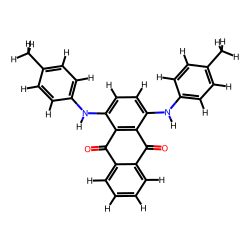

In [29]:
AllChem.EmbedMolecule(m3d, randomSeed=10)
AllChem.MMFFOptimizeMolecule(m3d)
Draw.MolToImage(m3d, size=(250,250))

## 距离几何+ETKDG+MMFF生成多构象

其实当使用ETKDG算法生成3D构象时，通常无需再使用MMFF94力场优化。如果执意要这么做，有一个方便的函数可以调用

使用MMFF94优化多个构象：`MMFFOptimizeMoleculeConfs()`
返回的结果是元组组成的列表，每个元组表示**每个构象的收敛值**和**能量(not_converged, energy)**。如果`not_converged`是0，则收敛，接近最稳态，否则没有到达最稳态。



In [30]:
res = AllChem.MMFFOptimizeMoleculeConfs(m3d)
res

[(0, 102.33441624587803)]

## 多线程生成多构象

可以通过numThreads参数进行设置。
- `EmbedMultipleConfs(mol, numThreads)`
- `MMFFOptimizeMoleculeConfs(mol, numThreads)`
    - `numThreads`：默认为1，表示单进程执行。设置为0表示将会使用本机最大线程数执行。

In [31]:
cids = AllChem.EmbedMultipleConfs(m3d, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m3d, numThreads=0)
